In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import transforms

from skimage.feature import hog

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss, top_k_accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV

### Load data and obtain train-test split

In [2]:
train_data = pd.read_csv('../data/fashion-mnist_train.csv')
test_data = pd.read_csv('../data/fashion-mnist_test.csv')

X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

print(f"Data with {len(X_train.columns)} features")
print(f"Train set of size {len(X_train)} with {len(y_train)} labels")
print(f"Test set of size {len(X_test)} with {len(y_test)} labels")

Data with 784 features
Train set of size 60000 with 60000 labels
Test set of size 10000 with 10000 labels


In [3]:
# Define class mappings
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [4]:
# Resize flattened images to 28x28 for Train and Test sets
X_train_images = [row.values.reshape(28, 28).astype('uint8') for _, row in X_train.iterrows()]
X_test_images = [row.values.reshape(28, 28).astype('uint8') for _, row in X_test.iterrows()]

### Visualise raw data

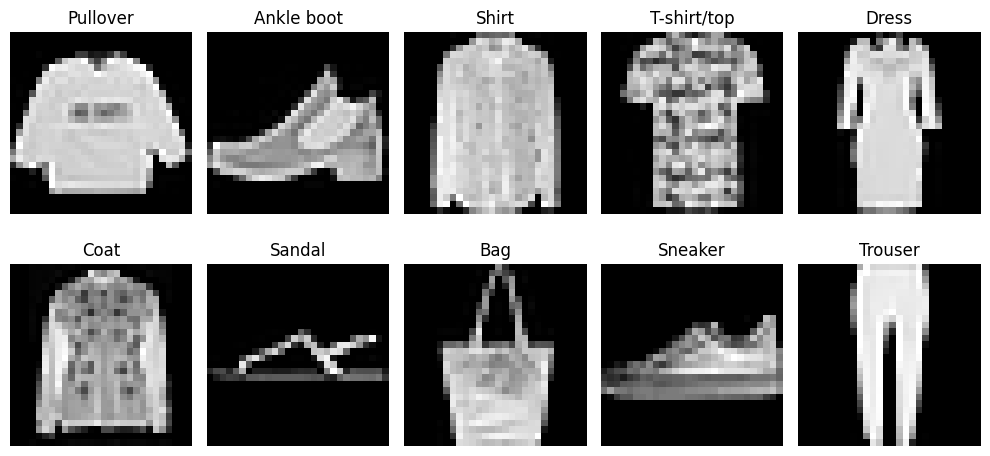

In [5]:
fig, ax = plt.subplots(2,5,figsize=(10,5))
shown = []
row, col = 0, 0

for idx, _img in enumerate(X_train_images):
    if y_train[idx] not in shown:
        ax[row][col].imshow(_img, cmap='gray')
        ax[row][col].set_title(f"{class_names[y_train[idx]]}")
        ax[row][col].set_axis_off()
        shown.append(y_train[idx])
        col += 1
        row += int(col/5)
        col = col%5

fig.tight_layout()
plt.show()

### Data Preprocessing: PCA

In [6]:
X_train_pca, y_train_pca = torch.load("./train_tensors.pt")
X_test_pca, y_test_pca = torch.load("./test_tensors.pt")

# Convert to arrays
X_train_pca = X_train_pca.numpy()
y_train_pca = y_train_pca.numpy()
X_test_pca = X_test_pca.numpy()
y_test_pca = y_test_pca.numpy()

In [7]:
print("Train Logistic Regression with preprocessed PCA data")
print(f"{len(X_train_pca)} training data with {len(X_train_pca[0])} features each")
print(f"{len(y_train_pca)} training labels")

# Scale train features (also fit the scaler with train data)
pca_scaler = StandardScaler()
X_train_pca = pca_scaler.fit_transform(X_train_pca)

# With tuned hyperparameters
lr_pca = LogisticRegression(
    C=0.1,
    max_iter=50000,
    penalty='l2',
    solver='lbfgs',
    # Tuned parameters below but takes too long to run (?)
    # penalty='l1',
    # solver='saga'
)

lr_pca.fit(X_train_pca, y_train_pca)

Train Logistic Regression with preprocessed PCA data
60000 training data with 186 features each
60000 training labels


LogisticRegression(C=0.1, max_iter=50000)

In [8]:
# Scale test features
X_test_pca = pca_scaler.transform(X_test_pca)
print(f"Test set of size {len(X_test_pca)}")

# Predict for train and test set
pca_train_predictions = lr_pca.predict(X_train_pca)
pca_test_predictions = lr_pca.predict(X_test_pca)

pca_train_acc = accuracy_score(y_train_pca, pca_train_predictions)
pca_test_acc = accuracy_score(y_test_pca, pca_test_predictions)
print("Training Accuracy:", pca_train_acc)
print("Test Accuracy:", pca_test_acc)

Test set of size 10000
Training Accuracy: 0.8614666666666667
Test Accuracy: 0.8551


In [9]:
# Numbers will be replaced by "0" if zero division occurs
print(classification_report(y_test_pca, pca_test_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1000
           1       0.97      0.97      0.97      1000
           2       0.77      0.77      0.77      1000
           3       0.86      0.88      0.87      1000
           4       0.78      0.80      0.79      1000
           5       0.92      0.92      0.92      1000
           6       0.66      0.60      0.63      1000
           7       0.90      0.91      0.91      1000
           8       0.95      0.95      0.95      1000
           9       0.93      0.94      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.85      0.86      0.85     10000



### Data Preprocessing: Feature Extraction with HOG

In [10]:
def extract_hog(images):

    hog_features = []
    hog_viz = []

    for _img in images:

        fd, viz = hog(
            _img,
            orientations=8,
            pixels_per_cell=(4, 4),
            cells_per_block=(1, 1),
            visualize=True,
            channel_axis=None
        )

        hog_features.append(fd)
        hog_viz.append(viz)

    return hog_viz, np.array(hog_features)

In [11]:
hog_train_viz, hog_train_features = extract_hog(X_train_images)
hog_test_viz, hog_test_features = extract_hog(X_test_images)

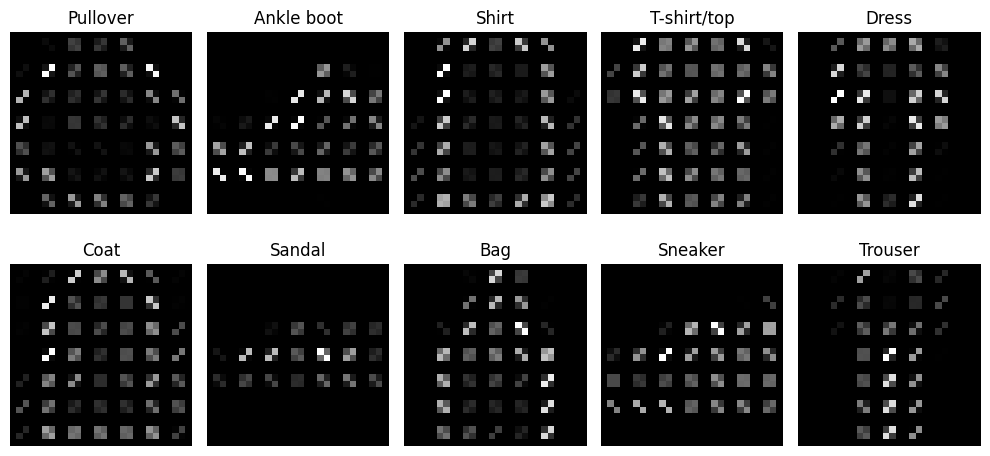

In [12]:
# Visualise keypoints
fig, ax = plt.subplots(2,5,figsize=(10,5))
shown = []
row, col = 0, 0

for idx, _img in enumerate(hog_train_viz):

    if y_train[idx] not in shown:

        ax[row][col].imshow(_img, cmap='gray')
        ax[row][col].set_title(f"{class_names[y_train[idx]]}")
        ax[row][col].set_axis_off()
        shown.append(y_train[idx])
        col += 1
        row += int(col/5)
        col = col%5

fig.tight_layout()
plt.show()

In [13]:
print("Train Logistic Regression with preprocessed HOG data")
print(f"{len(hog_train_features)} training data with {len(hog_train_features[0])} features each")
print(f"{len(y_train)} training labels")

# Scale train features (also fit the scaler with train data)
hog_scaler = StandardScaler()
hog_train_features = hog_scaler.fit_transform(hog_train_features)

# With tuned hyperparameters
lr_hog = LogisticRegression(
    C=0.1,
    max_iter=50000,
    penalty='l2',
    solver='lbfgs',
    # Tuned parameters below but takes too long to run (?)
    # penalty='l1',
    # solver='saga'
)

lr_hog.fit(hog_train_features, y_train)

Train Logistic Regression with preprocessed HOG data
60000 training data with 392 features each
60000 training labels


LogisticRegression(C=0.1, max_iter=50000)

In [14]:
# Scale test features
hog_test_features = hog_scaler.transform(hog_test_features)
print(f"Test set of size {len(hog_test_features)}")

# Predict for train and test set
hog_train_predictions = lr_hog.predict(hog_train_features)
hog_test_predictions = lr_hog.predict(hog_test_features)

hog_train_acc = accuracy_score(y_train, hog_train_predictions)
hog_test_acc = accuracy_score(y_test, hog_test_predictions)
print("Training Accuracy:", hog_train_acc)
print("Test Accuracy:", hog_test_acc)

Test set of size 10000
Training Accuracy: 0.8823833333333333
Test Accuracy: 0.8702


In [15]:
# Numbers will be replaced by "0" if zero division occurs
print(classification_report(y_test, hog_test_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1000
           1       0.96      0.97      0.97      1000
           2       0.82      0.79      0.80      1000
           3       0.87      0.89      0.88      1000
           4       0.78      0.83      0.81      1000
           5       0.96      0.93      0.94      1000
           6       0.68      0.61      0.64      1000
           7       0.91      0.92      0.92      1000
           8       0.96      0.97      0.96      1000
           9       0.93      0.95      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



### Data Preprocessing: Feature Extraction with SIFT

In [16]:
resize_factor = (100,100)

def sift(images, resize):
    
    sift_detector = cv2.SIFT_create()
    keypoints = []
    features = []

    for _img in images:
        
        # Resize as SIFT works better on larger images
        resized = cv2.resize(_img, resize, interpolation=cv2.INTER_CUBIC)
        
        kp, des = sift_detector.detectAndCompute(resized, None)
        
        # Handles missing keypoints
        if des is None:
            des = np.zeros((1, 128))
        pooled = np.mean(des, axis=0)
        
        keypoints.append(kp)
        features.append(pooled)

    return keypoints, np.array(features)

In [17]:
sift_train_keypoints, sift_train_features = sift(X_train_images, resize_factor)
sift_test_keypoints, sift_test_features = sift(X_test_images, resize_factor)

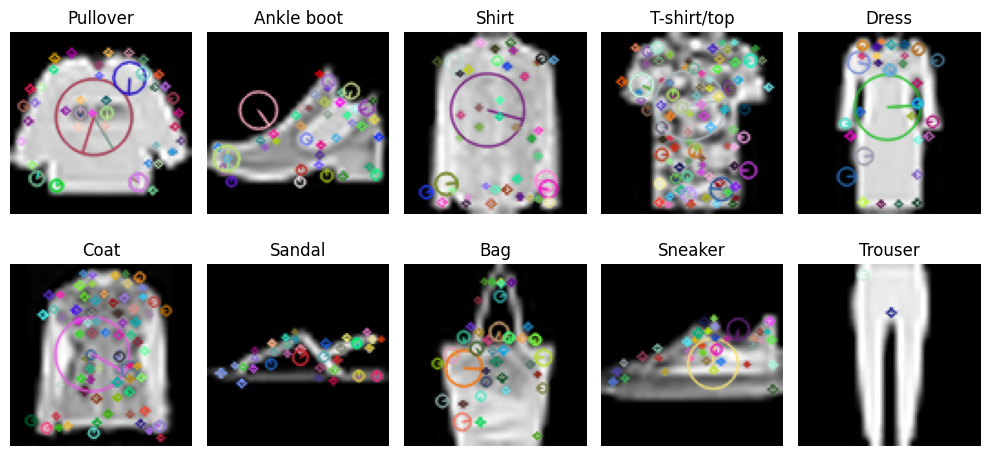

In [18]:
# Visualise keypoints
fig, ax = plt.subplots(2,5,figsize=(10,5))
shown = []
row, col = 0, 0

for idx, _img in enumerate(X_train_images):
    
    if y_train[idx] not in shown:
        resized = cv2.resize(_img, resize_factor, interpolation=cv2.INTER_CUBIC)
        _kp = sift_train_keypoints[idx]
        img_kp = cv2.drawKeypoints(resized, _kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        ax[row][col].imshow(img_kp, cmap='gray')
        ax[row][col].set_title(f"{class_names[y_train[idx]]}")
        ax[row][col].set_axis_off()
        shown.append(y_train[idx])
        col += 1
        row += int(col/5)
        col = col%5

fig.tight_layout()
plt.show()

In [19]:
print("Train Logistic Regression with preprocessed SIFT data")
print(f"{len(sift_train_features)} training data with {len(sift_train_features[0])} features each")
print(f"{len(y_train)} training labels")

# Scale train features (also fit the scaler with train data)
sift_scaler = StandardScaler()
sift_train_features = sift_scaler.fit_transform(sift_train_features)

# With tuned hyperparameters
lr_sift = LogisticRegression(
    C=0.1,
    max_iter=50000,
    penalty='l2',
    solver='lbfgs',
    # Tuned parameters below but takes too long to run (?)
    # penalty='l1',
    # solver='saga'
)

lr_sift.fit(sift_train_features, y_train)

Train Logistic Regression with preprocessed SIFT data
60000 training data with 128 features each
60000 training labels


LogisticRegression(C=0.1, max_iter=50000)

In [20]:
# Scale test features
sift_test_features = sift_scaler.transform(sift_test_features)
print(f"Test set of size {len(sift_test_features)}")

# Predict for train and test set
sift_train_predictions = lr_sift.predict(sift_train_features)
sift_test_predictions = lr_sift.predict(sift_test_features)

sift_train_acc = accuracy_score(y_train, sift_train_predictions)
sift_test_acc = accuracy_score(y_test, sift_test_predictions)
print("Training Accuracy:", sift_train_acc)
print("Test Accuracy:", sift_test_acc)

Test set of size 10000
Training Accuracy: 0.6627166666666666
Test Accuracy: 0.6491


In [21]:
# Numbers will be replaced by "0" if zero division occurs
print(classification_report(y_test, sift_test_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.57      0.58      0.58      1000
           1       0.86      0.88      0.87      1000
           2       0.62      0.56      0.59      1000
           3       0.51      0.45      0.48      1000
           4       0.55      0.55      0.55      1000
           5       0.79      0.83      0.81      1000
           6       0.41      0.38      0.40      1000
           7       0.72      0.77      0.75      1000
           8       0.64      0.68      0.66      1000
           9       0.76      0.80      0.78      1000

    accuracy                           0.65     10000
   macro avg       0.64      0.65      0.65     10000
weighted avg       0.64      0.65      0.65     10000



### Data Preprocessing: Image Augmentations


In [22]:
# Generate one augmented image per original image
X_train_images_augmented = []
y_train_augmented = []

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30)
])

for i, _image in enumerate(X_train_images):
    
    # One augmented image for each existing image
    _image_pil = Image.fromarray(_image.astype('uint8'))
    _image_augmented_pil = transform(_image_pil)
    _image_augmented = np.array(_image_augmented_pil)

    X_train_images_augmented.append(_image)
    X_train_images_augmented.append(_image_augmented)

    y_train_augmented.append(y_train[i])
    y_train_augmented.append(y_train[i])

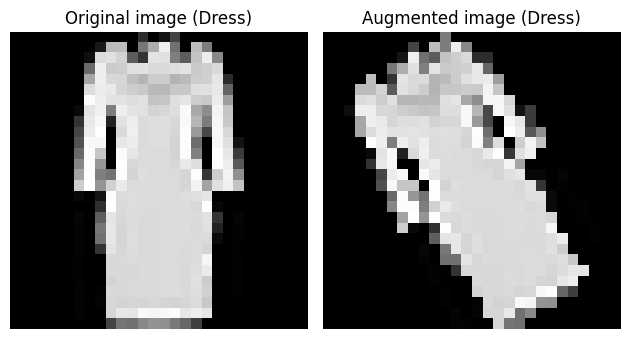

In [23]:
# To visualise sample augmented image
sample_image = X_train_images_augmented[8]
sample_image_augmented = X_train_images_augmented[9]

fig,ax = plt.subplots(1,2)
ax[0].imshow(sample_image, cmap='gray')
ax[0].axis('off')
ax[0].set_title(f"Original image ({class_names[y_train_augmented[8]]})")
ax[1].imshow(sample_image_augmented, cmap='gray')
ax[1].axis('off')
ax[1].set_title(f"Augmented image ({class_names[y_train_augmented[9]]})")
fig.tight_layout()
plt.show()

In [24]:
# Flatten images
X_train_augmented = [i.flatten() for i in X_train_images_augmented]

print("Train Logistic Regression with additional augmented data")
print(f"{len(X_train_augmented)} training data with {len(X_train_augmented[0])} features each")
print(f"{len(y_train_augmented)} training labels")

# Scale train features (also fit the scaler with train data)
augmented_scaler = StandardScaler()
X_train_augmented = augmented_scaler.fit_transform(X_train_augmented)

# With tuned hyperparameters
lr_augmented = LogisticRegression(
    C=0.1,
    max_iter=50000,
    penalty='l2',
    solver='lbfgs',
    # Tuned parameters below but takes too long to run (?)
    # penalty='l1',
    # solver='saga'
)

lr_augmented.fit(X_train_augmented, y_train_augmented)

Train Logistic Regression with additional augmented data
120000 training data with 784 features each
120000 training labels


LogisticRegression(C=0.1, max_iter=50000)

In [25]:
# Scale test features
X_test_augmented = augmented_scaler.transform(X_test)
print(f"Test set of size {len(X_test_augmented)}")

# Predict for train and test set
augmented_train_predictions = lr_augmented.predict(X_train_augmented)
augmented_test_predictions = lr_augmented.predict(X_test_augmented)

augmented_train_acc = accuracy_score(y_train_augmented, augmented_train_predictions)
augmented_test_acc = accuracy_score(y_test, augmented_test_predictions)
print("Training Accuracy:", augmented_train_acc)
print("Test Accuracy:", augmented_test_acc)

Test set of size 10000


C:\Users\limZH\OneDrive\NUS\Y3\Y3S2\CS3244\Project\venv_pc\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Training Accuracy: 0.8024333333333333
Test Accuracy: 0.8283


In [26]:
# Numbers will be replaced by "0" if zero division occurs
print(classification_report(y_test, augmented_test_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      1000
           1       0.94      0.96      0.95      1000
           2       0.76      0.74      0.75      1000
           3       0.85      0.86      0.85      1000
           4       0.77      0.81      0.79      1000
           5       0.84      0.86      0.85      1000
           6       0.65      0.57      0.61      1000
           7       0.87      0.89      0.88      1000
           8       0.93      0.89      0.91      1000
           9       0.87      0.90      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



### Train Logistic Regression

In [27]:
print("Train Logistic Regression on raw data")
print(f"{len(X_train)} training data with {len(X_train.columns)} features each")
print(f"{len(y_train)} training labels")

# Scale train features (also fit the scaler with train data)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# With tuned hyperparameters
lr = LogisticRegression(
    C=0.1,
    max_iter=50000,
    penalty='l2',
    solver='lbfgs',
    # Tuned parameters below but takes too long to run (?)
    # penalty='l1',
    # solver='saga'
)

lr.fit(X_train, y_train)

Train Logistic Regression on raw data
60000 training data with 784 features each
60000 training labels


LogisticRegression(C=0.1, max_iter=50000)

In [28]:
# Scale test features
X_test = scaler.transform(X_test)
print(f"Test set of size {len(X_test)}")

train_predictions = lr.predict(X_train)
test_predictions = lr.predict(X_test)

train_acc = accuracy_score(y_train, train_predictions)
test_acc = accuracy_score(y_test, test_predictions)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Test set of size 10000
Training Accuracy: 0.8827
Test Accuracy: 0.8514


In [29]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1000
           1       0.95      0.97      0.96      1000
           2       0.77      0.76      0.76      1000
           3       0.86      0.86      0.86      1000
           4       0.78      0.80      0.79      1000
           5       0.94      0.91      0.92      1000
           6       0.64      0.59      0.62      1000
           7       0.90      0.92      0.91      1000
           8       0.94      0.93      0.94      1000
           9       0.93      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



### Evaluate Logistic Regression with HOG

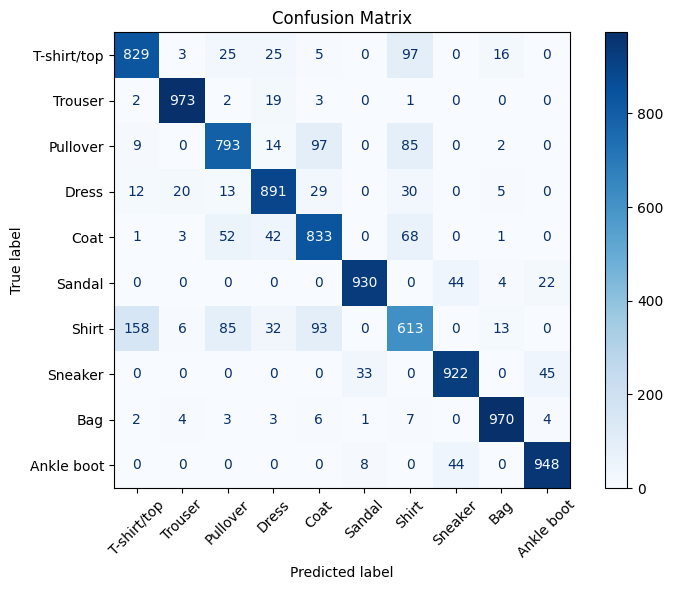

In [30]:
cm = confusion_matrix(y_test, hog_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names.values())
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
print(classification_report(y_test, hog_test_predictions))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1000
           1       0.96      0.97      0.97      1000
           2       0.82      0.79      0.80      1000
           3       0.87      0.89      0.88      1000
           4       0.78      0.83      0.81      1000
           5       0.96      0.93      0.94      1000
           6       0.68      0.61      0.64      1000
           7       0.91      0.92      0.92      1000
           8       0.96      0.97      0.96      1000
           9       0.93      0.95      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [32]:
# Log Loss
y_prob = lr_hog.predict_proba(hog_test_features)
logloss = log_loss(y_test, y_prob)
print(f"Log loss: {logloss:.4f}")

# Class Accuracy

# Top-k Accuracy
top3_acc = top_k_accuracy_score(y_test, y_prob, k=3)
print(f"Top-3 Accuracy: {top3_acc:.4f}")

# AUC-ROC, AUC-PR
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
roc_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
pr_auc = average_precision_score(y_test_bin, y_prob, average='macro')
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

Log loss: 0.3670
Top-3 Accuracy: 0.9885
AUC-ROC: 0.9885
PR-AUC: 0.9238


### Tune hyperparameters for Logistic Regression

In [3]:
# Define hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2', 'none'],
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [50000],
    'tol': [1e-4],
}

n_combi = 1
for i in param_grid:
    n_combi *= len(param_grid[i])
print(f"{n_combi} hyperparameter combinations")

18 hyperparameter combinations


In [ ]:
# Grid search to find the best combination of hyperparameter
# `cv`parameter is for cross validation, which ensures reliable evaluation of each hyperparameter combination
# TAKES VERY LONG TO RUN !!! Hyperparameter tuning was done with data size 10000 which took ~ 1 hour
scaler = StandardScaler()
X_tune = scaler.fit_transform(X_train[:10000])

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_tune, y_train[:10000])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
